### Goal
Compute the correlation matrix between samples. We want to avoid with this analysis bad samples or mismatch samples.

### TODO
- 1. Find a subset of candidates genes for which we could have good prediction
   - 1.1 Expression distribution (of all/single genes over all/single tissues)
   - 1.2 Determine genes which are not expressed in most tissues 
   - 1.3 Determine genes which are strongly expressed

- 2. Sample matching matrix

### Conclusions
1. 
  - we found ~1000 genes which are not expressed in most of the tissues (these genes we should remove from our training features): `/s/rep/processed/gtex/input_data/genes_subset/not_expressed_genes.txt`
  - we found 39 genes to be highly expressed (varies also over the tissues and over the individuals): `/s/rep/processed/gtex/input_data/genes_subset/highly_expressed_genes.txt`
  - determine genes which are expressed in most tissues 
 
2. 

## 1. Find a subset of candidates genes for which we could have good prediction

In [1]:
import os
import sys

import pandas as pd
import numpy as np
from rep import preprocessing_new as p
import warnings; warnings.simplefilter('ignore')

/opt/modules/i12g/anaconda/3-5.0.1/envs/rep/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
gtex = p.load(os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_norm_tmp.h5ad"))

In [3]:
all_tissues = gtex.samples['Tissue'].drop_duplicates().tolist()
all_tissues

['Lung',
 'Brain - Cerebellar Hemisphere',
 'Heart - Left Ventricle',
 'Skin - Sun Exposed (Lower leg)',
 'Brain - Amygdala',
 'Adipose - Subcutaneous',
 'Brain - Cortex',
 'Uterus',
 'Nerve - Tibial',
 'Muscle - Skeletal',
 'Ovary',
 'Whole Blood',
 'Brain - Nucleus accumbens (basal ganglia)',
 'Colon - Transverse',
 'Adipose - Visceral (Omentum)',
 'Adrenal Gland',
 'Brain - Substantia nigra',
 'Thyroid',
 'Esophagus - Mucosa',
 'Artery - Coronary',
 'Esophagus - Muscularis',
 'Brain - Caudate (basal ganglia)',
 'Heart - Atrial Appendage',
 'Esophagus - Gastroesophageal Junction',
 'Colon - Sigmoid',
 'Artery - Tibial',
 'Liver',
 'Prostate',
 'Testis',
 'Cells - Transformed fibroblasts',
 'Brain - Putamen (basal ganglia)',
 'Kidney - Cortex',
 'Pancreas',
 'Stomach',
 'Small Intestine - Terminal Ileum',
 'Brain - Hippocampus',
 'Brain - Cerebellum',
 'Pituitary',
 'Breast - Mammary Tissue',
 'Skin - Not Sun Exposed (Suprapubic)',
 'Brain - Frontal Cortex (BA9)',
 'Artery - Aorta',
 

### 1. Expression distribution (of all/single genes over all/single tissues)

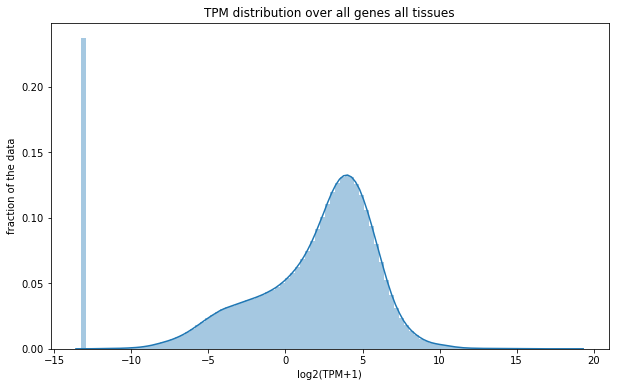

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.distplot(np.log2(np.array(gtex.X)+0.0001).flatten(),bins=100)
plt.title("TPM distribution over all genes all tissues")
plt.xlabel("log2(TPM+1)")
plt.ylabel("fraction of the data")
fig = plt.gcf()
fig.set_size_inches(10, 6)

#### 1.1 Find genes low expressed within tissue / genes highly expressed over all tissues

In [8]:
log_gtex = np.log2(np.array(gtex.X)+0.0001)
gtex_log_obj = p.RepAnnData(X=log_gtex, samples_obs = gtex.samples, genes_var = gtex.genes) 

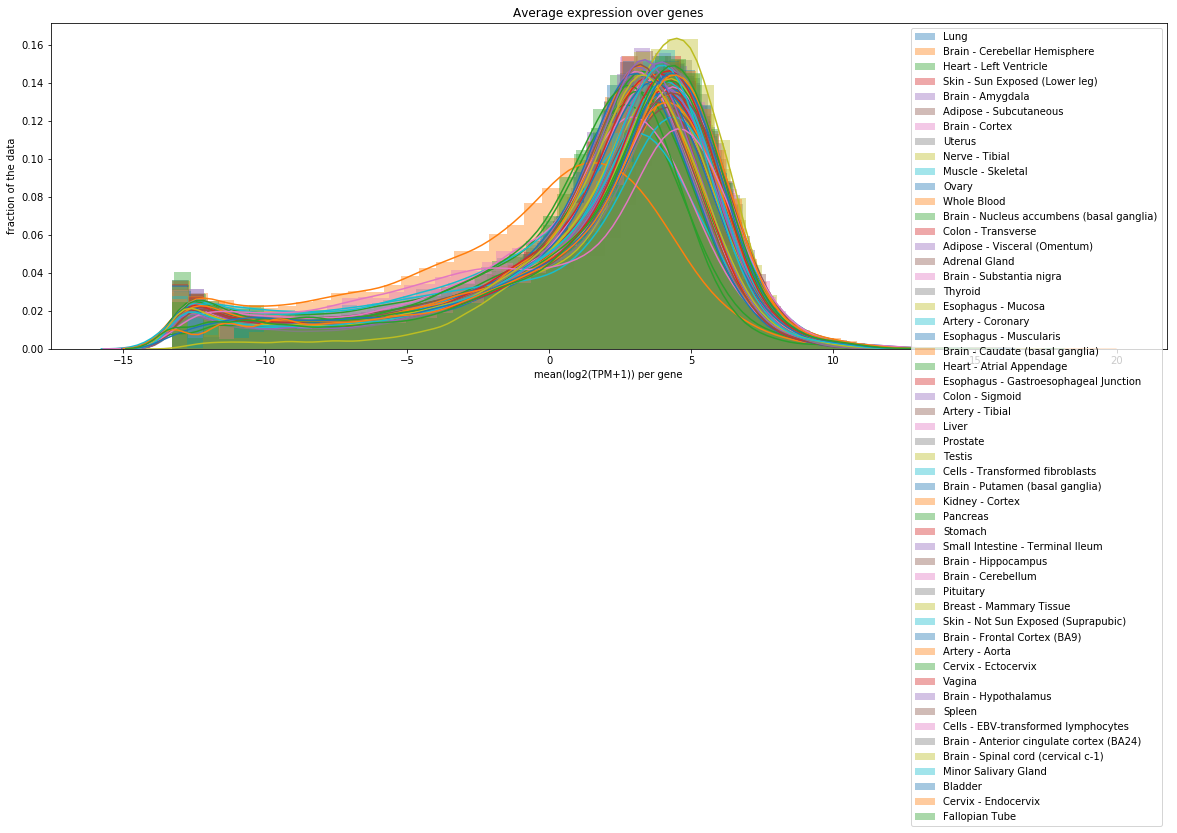

In [9]:
genes = gtex.genes['gene_id'].tolist()
df_mean_expression = pd.DataFrame(columns=['Tissue']+genes)

for t in all_tissues:
    tmp = np.array(gtex_log_obj[gtex_log_obj.samples['Tissue'] == t].X)
    avg_per_gene = np.mean(tmp, axis = 0)
    
    dict = {}
    dict['Tissue'] = t
    for i, g in enumerate(avg_per_gene): dict[genes[i]] = g
    df_mean_expression = df_mean_expression.append(dict, ignore_index = True)
    
    ax = sns.distplot(avg_per_gene,bins=50, label=t)
    plt.title(f'Average expression over genes')
    plt.xlabel("mean(log2(TPM+1)) per gene")
    plt.ylabel("fraction of the data")
    plt.legend(loc='upper right')
    fig = plt.gcf()
    fig.set_size_inches(20, 6) 
    fig

In [10]:
df_mean_expression[:10]

,Tissue,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,...,ENSG00000283619.1,ENSG00000283620.1,ENSG00000283623.1,ENSG00000283632.1,ENSG00000283644.1,ENSG00000283652.1,ENSG00000283654.1,ENSG00000283663.1,ENSG00000283683.1,ENSG00000283697.1
0,Lung,3.943801,-6.214041,5.173578,3.450576,2.040806,7.090202,6.284169,5.164249,3.850442,...,-10.770146,2.520930,4.428085,1.743943,-9.446659,2.051381,-2.638537,0.568425,-2.430806,0.680114
1,Brain - Cerebellar Hemisphere,1.245752,-8.146817,4.953719,3.640168,2.620233,1.466963,1.596938,2.924493,3.539217,...,0.309926,3.624976,3.854318,-4.249398,-11.116225,-2.972604,-2.334617,-8.225741,-3.008695,-0.166669
2,Heart - Left Ventricle,1.605699,-4.140268,4.309935,1.625040,0.110290,2.003681,3.369285,3.685265,2.362870,...,-11.248146,1.319359,2.574256,-1.014457,-10.350126,-2.688486,-4.037136,-4.395918,-3.427988,-0.521133
3,Skin - Sun Exposed (Lower leg),3.621655,1.376665,5.151831,3.817172,2.269004,2.680849,6.110233,3.886073,3.914965,...,-8.684775,2.709577,3.572191,0.454475,-9.720449,-1.013912,-3.983669,2.453983,-2.392794,0.098452
4,Brain - Amygdala,3.341806,-3.467016,3.873667,1.971785,0.732728,2.239517,2.619524,3.205052,3.715302,...,-1.315263,1.889062,2.980920,-4.242363,-12.277778,-1.373153,-2.691699,-4.914684,-5.984719,-1.134730
5,Adipose - Subcutaneous,5.191257,4.257599,5.289722,3.622822,2.276242,4.881681,7.032775,5.157932,4.405021,...,-11.182916,2.222905,4.546440,1.666397,-9.576757,0.214495,-2.926263,-3.100049,0.305315,0.394869
6,Brain - Cortex,2.664136,-2.671904,4.412135,2.426099,1.075684,2.573745,2.510438,2.976326,3.712987,...,-0.703634,3.116572,3.694788,-3.642618,-11.370638,-1.619139,-1.770554,-3.154839,-5.953071,-0.871295
7,Uterus,5.180274,-2.583321,5.564866,3.963412,2.726532,3.920539,3.467286,4.927145,3.809125,...,-10.740631,3.596838,4.736158,2.708900,-8.771736,-1.183373,-2.187551,-1.811893,-1.914332,1.039251
8,Nerve - Tibial,5.236478,1.542537,5.386381,3.963520,2.841871,4.012143,7.477007,5.106817,3.831521,...,-1.226823,2.886319,4.371704,0.774996,-9.083086,0.031074,-2.870728,-4.336621,2.528438,0.874151
9,Muscle - Skeletal,1.539274,-1.946306,4.817595,2.569665,0.693600,1.252053,3.235214,1.903115,2.608598,...,-8.432125,1.777424,3.769014,-1.742143,-9.195038,-3.480943,-4.090547,0.606422,-1.120137,-0.690320


In [11]:
not_expressed_genes = []
highly_expressed_genes = []
for g in genes:
    if np.mean(df_mean_expression[g].tolist()) <= -10:
        not_expressed_genes.append(g)
    if np.mean(df_mean_expression[g].tolist()) >= 10:
        highly_expressed_genes.append(g)

### 2. Determine genes which are not expressed in most tissues 

In [102]:
print("Genes not expressed in at least one tissues: " + str(len(not_expressed_genes)))

Genes not expressed in at least one tissues: 974


In [201]:
out = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","input_data","genes_subset","not_expressed_genes.txt")
with open(out, 'w') as f:
    for item in not_expressed_genes:
        f.write("%s\n" % item)

In [121]:
import seaborn as sns; sns.set(color_codes=True)

df = df_mean_expression.filter(['Tissue'] + not_expressed_genes)
df.fillna(-20, inplace=True)
df.set_index('Tissue', inplace=True)

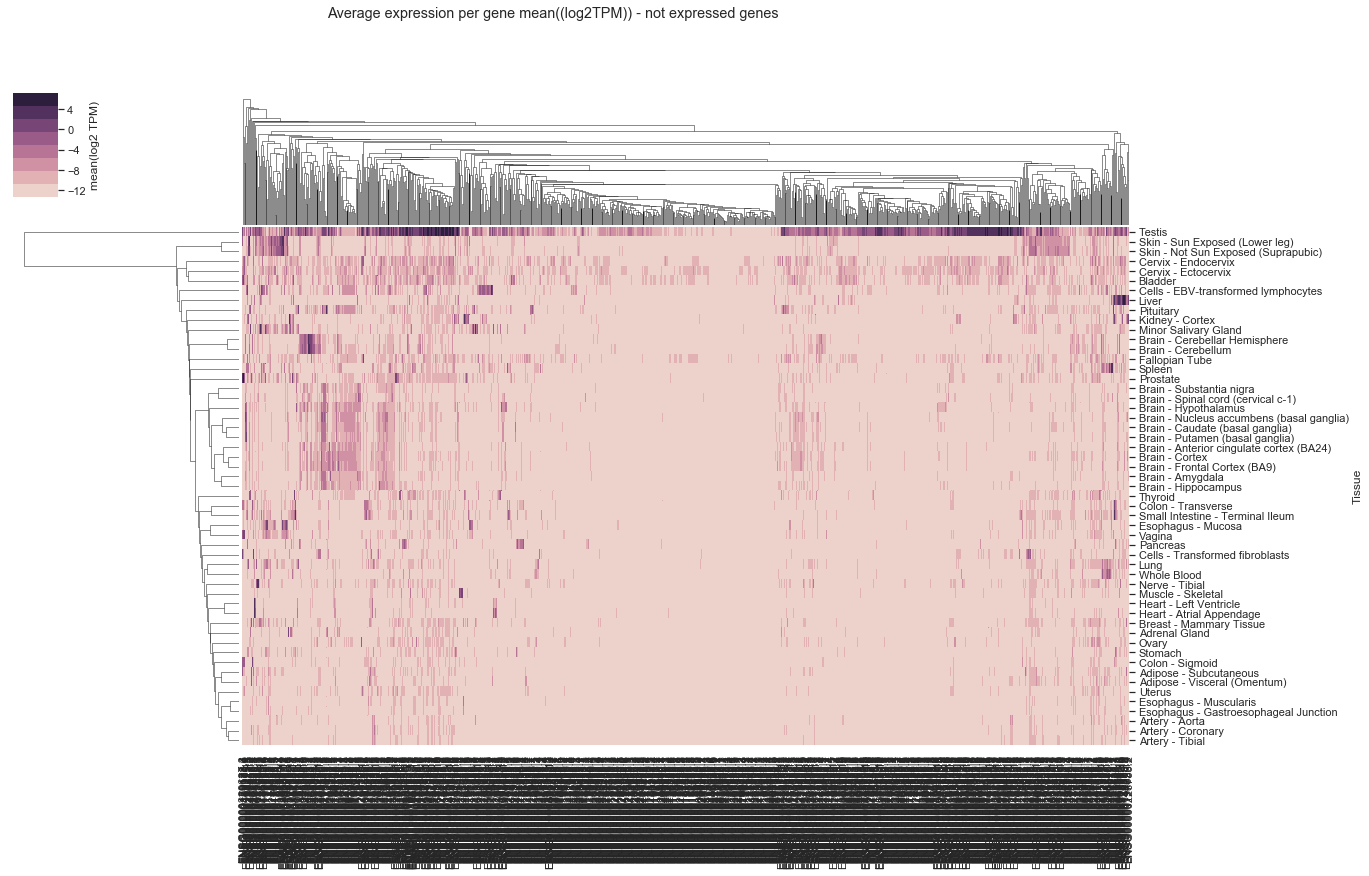

In [126]:
ax = sns.clustermap(df,
#                  xticklabels=gtex.genes[gtex.genes['gene_id'].isin(highly_expressed_genes)]['symbol'].tolist(),
                 xticklabels=df.columns.tolist(),
                 yticklabels=df.index.tolist(),
                 cmap=sns.cubehelix_palette(8))
ax.fig.suptitle("Average expression per gene mean((log2TPM)) - not expressed genes")
plt.ylabel("mean(log2 TPM)")
fig = plt.gcf()
fig.set_size_inches(20, 12) 

### 3. Determine genes which are expressed in most tissues 

In [32]:
print("Genes highly expressed: " + str(len(highly_expressed_gene)))

Genes highly expressed: 39


In [33]:
highly_expressed_genes[:10]

['ENSG00000075624.13',
 'ENSG00000087086.14',
 'ENSG00000092841.18',
 'ENSG00000105193.8',
 'ENSG00000105372.6',
 'ENSG00000108298.9',
 'ENSG00000111640.14',
 'ENSG00000124942.13',
 'ENSG00000133112.16',
 'ENSG00000137154.12']

In [12]:
import seaborn as sns; sns.set(color_codes=True)

df = df_mean_expression.filter(['Tissue'] + highly_expressed_genes)
df.set_index('Tissue', inplace=True)

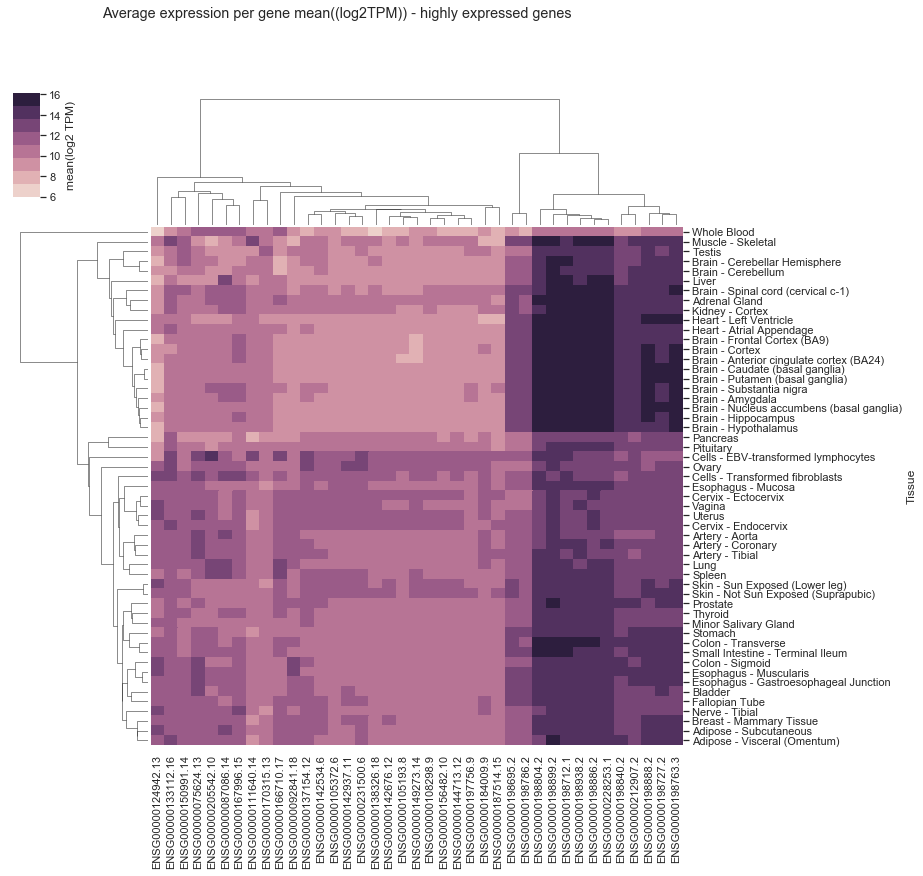

In [13]:
ax = sns.clustermap(df,
#                  xticklabels=gtex.genes[gtex.genes['gene_id'].isin(highly_expressed_genes)]['symbol'].tolist(),
                 xticklabels=df.columns.tolist(),
                 yticklabels=df.index.tolist(),
                 cmap=sns.cubehelix_palette(8))
ax.fig.suptitle("Average expression per gene mean((log2TPM)) - highly expressed genes")
plt.ylabel("mean(log2 TPM)")
fig = plt.gcf()
fig.set_size_inches(12, 12) 

In [14]:
gtex = p.load(os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_logratios.h5ad"))
gtex_filtered = gtex[:,gtex.genes['gene_id'].isin(highly_expressed_genes)]
df_data = pd.concat([
                    pd.DataFrame(columns=['Tissue','Sample'], data={'Tissue': gtex_filtered.obs['Tissue'].tolist(),
                                                                   'Sample':gtex_filtered.obs.index.tolist()}),
                    pd.DataFrame.from_records(columns=gtex_filtered.var.index.tolist(), data=gtex_filtered.X)], axis=1, ignore_index=True)


df_data.columns = ["Tissue", 'Sample'] + highly_expressed_genes

# subsample Whole Blood and Muscle 
df_data = df_data[df_data["Tissue"].isin(["Whole Blood","Muscle - Skeletal"])]

# set index and sort by tissue
df_data.set_index('Sample', inplace=True)
df_data.sort_values("Tissue", inplace=True)

# group by tissues
tissues  = df_data.pop("Tissue")

In [15]:
tissues_lut = {k: v for k, v in  zip(tissues.unique(), sns.color_palette("muted", len(tissues.unique().tolist())))}
tissues_colors = tissues.map(tissues_lut)
tissues_labels = tissues

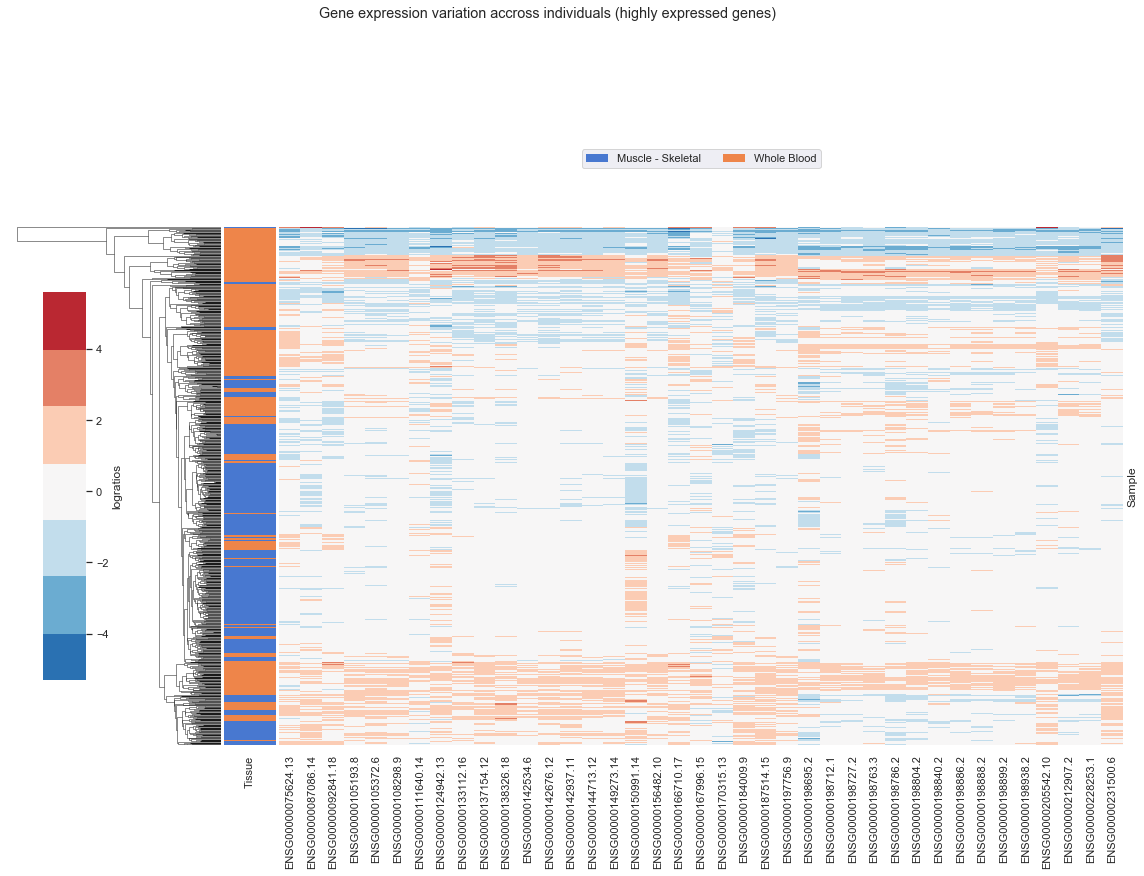

In [16]:
ax = sns.clustermap(df_data,
#                  xticklabels=gtex.genes[gtex.genes['gene_id'].isin(highly_expressed_genes)]['symbol'].tolist(),
                 xticklabels=df.columns.tolist(),
#                  yticklabels=df.index.tolist(),
                 yticklabels=False,
                 cmap=sns.color_palette("RdBu_r", 7),
                 row_colors=tissues_colors,
                  # Turn off the clustering
                  row_cluster=True, col_cluster=False,
                 center=0)

for label in tissues_labels.unique():
    ax.ax_col_dendrogram.bar(0, 0, color=tissues_lut[label],
                            label=label, linewidth=0)

ax.ax_col_dendrogram.legend(loc="center", ncol=7)
ax.cax.set_position([.15, .2, .03, .45])

ax.fig.suptitle("Gene expression variation accross individuals (highly expressed genes)")
plt.ylabel("logratios")
fig = plt.gcf()
fig.set_size_inches(20, 12) 

In [65]:
gtex = p.load(os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_logratios.h5ad"))
gtex_filtered = gtex[:,gtex.genes['gene_id'].isin(highly_expressed_genes)]

out = os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","input_data","genes_subset","highly_expressed_genes.txt")
with open(out, 'w') as f:
    for item in highly_expressed_genes:
        f.write("%s\n" % item)

In [66]:
mean_row = df_data.mean(axis=1).tolist()
index_negative_change = [i for i in mean_row if i < -0.01] 
samples_negative_change = df_data.iloc[index_negative_change, :].index
gtex_filtered.obs[gtex_filtered.obs.index.isin(samples_negative_change)]['Individual'].tolist()

['GTEX-WY7C', 'GTEX-14A6H', 'GTEX-P4PP', 'GTEX-POMQ']

In [67]:
mean_row = df_data.mean(axis=1).tolist()
index_positive_change = [i for i in mean_row if i > 0.01] 
samples_positive_change = df_data.iloc[index_positive_change, :].index
gtex_filtered.obs[gtex_filtered.obs.index.isin(samples_positive_change)]['Individual'].tolist()

['GTEX-WY7C', 'GTEX-PSDG', 'GTEX-12WSJ']

## 2. Sample matching matrix
Since the data seems to be noisy, we would like to run a sample matching test. We do expect that the samples of same individual cluster better compared to tissue grouping.

In [234]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

from rep import preprocessing_new as p
import warnings; warnings.simplefilter('ignore')

gtex = p.load(os.path.join(os.readlink(os.path.join("..","..","data")),"processed","gtex","recount","recount_gtex_norm_tmp.h5ad"))
gtex_filtered = gtex[gtex.samples['Tissue'].isin(["Whole Blood","Muscle - Skeletal", "Adipose - Subcutaneous"])]

In [235]:
# df_correlation = pd.DataFrame(columns=['Sample1','Sample2','From_Tissue','To_Tissue','From_Individual','To_Individual', 'Corr'])
data_correlation = []
samples = gtex_filtered.obs.index.tolist()[:50]
samples = shuffle(samples)

In [ ]:
for i,s1 in enumerate(samples[:-1]):
    print(i)
    print(len(samples[i:]))
    for s2 in samples[i:]:
        var1 = gtex_filtered[gtex_filtered.obs.index == s1]
        var2 = gtex_filtered[gtex_filtered.obs.index == s2]
        data_correlation.append({ 'Corr':np.corrcoef(np.array(var1.X).flatten(), np.array(var2.X).flatten())[0][1],
                                                 'Sample1':s1,
                                                 'Sample2':s2,
                                                 'From_Tissue':var1.obs['Tissue'].tolist()[0],
                                                 'To_Tissue':var2.obs['Tissue'].tolist()[0],
                                                 'From_Individual':var1.obs['Individual'].tolist()[0],
                                                 'To_Individual':var2.obs['Individual'].tolist()[0]})                               

0
50
1
49
2
48
3
47
4
46
5
45
6
44
7
43
8
42
9
41
10
40
11
39
12
38
13
37


In [240]:
df_correlation = pd.DataFrame(data=data_correlation)
df_correlation[:10]

In [ ]:
var1.obs.index

---- Obsolete

In [ ]:
from upsetplot import from_memberships

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import upsetplot

list_genes = gtex.genes['gene_id'].tolist()
genes_highly_expressed = pd.DataFrame(columns=gtex.genes['gene_id'].tolist())
for tissue in highly_expressed_genes:
    dict = {}
    dict['Tissue'] = tissue
#     for gene in list_genes: dict[gene] = False
    for gene in highly_expressed_genes[tissue]: dict[list_genes[gene]] = True
    genes_highly_expressed = genes_highly_expressed.append(dict, ignore_index=True)

In [ ]:
genes = [c for c in genes_highly_expressed.columns if c != "Tissue"]
genes_count_series = genes_highly_expressed.fillna(False).groupby(genes).count()["Tissue"]

In [ ]:
upsetplot.plot(genes_count_series, sort_by="cardinality")

In [ ]:
current_figure = plt.gcf()
current_figure.savefig("genes_highly_expressed.png")